In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
import itertools
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

import plotly.graph_objects as go

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

def plot_2D(f,bl = [0,0], ur=[1,1],name = None): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(bl[0], ur[0], Nx)
    ys = np.linspace(bl[1], ur[1], Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )
    if name is not None:
        plt.title(name)

    plt.show()


def plot_solution_adaptive(r1,r2,model,target,name=None): 
    # Plot function: test results 
    x_test = torch.linspace(r1,r2,200).view(-1,1).to(device)
    u_true = target(x_test)
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 200)
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt,'.',label = "nn function",markersize=5)
    plt.plot(x_model_pt.cpu(),torch.ones(u_model_pt.size()) * 1.05* min(u_true.cpu()),'.',label = "nodes",markersize=4)
#     plt.plot(x_model_pt,u_model_pt,'.r')
    plt.xlim(r1,r2) 
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()


In [ ]:
def plot_parameters_on_circle_interactive(my_model):
    w = my_model.fc1.weight.data.view(-1).cpu().numpy()
    b = my_model.fc1.bias.data.view(-1).cpu().numpy()
    norms = np.sqrt(w**2 + b**2)
    w_norm = w / norms
    b_norm = b / norms

    # Unit circle
    theta = np.linspace(0, 2 * np.pi, 500)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    fig = go.Figure()

    # Add unit circle
    fig.add_trace(go.Scatter(
        x=x_circle, y=y_circle,
        mode='lines',
        name='Unit Circle',
        line=dict(color='red', dash='dash', width=1)
    ))

    # Add (w, b) points
    fig.add_trace(go.Scatter(
        x=b, y=w,
        mode='markers',
        name='(w, b)',
        marker=dict(color='blue', size=4, opacity=0.8)
    ))

    # Plot layout
    fig.update_layout(
        title="Interactive Distribution of (w, b)",
        xaxis_title="b",
        yaxis_title="w",
        width=600, height=600,
        showlegend=True,
        xaxis=dict(scaleanchor='y', scaleratio=1),
        yaxis=dict(scaleanchor='x', scaleratio=1),
    )

    fig.show()

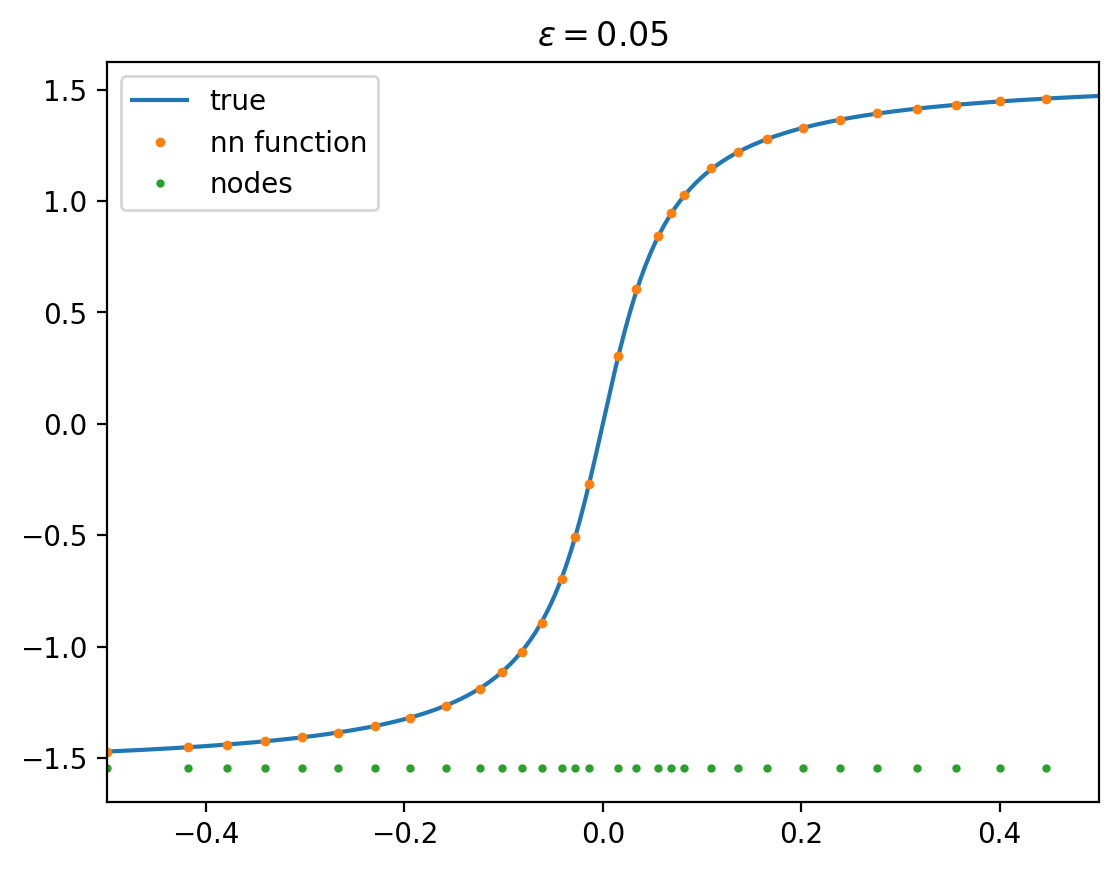

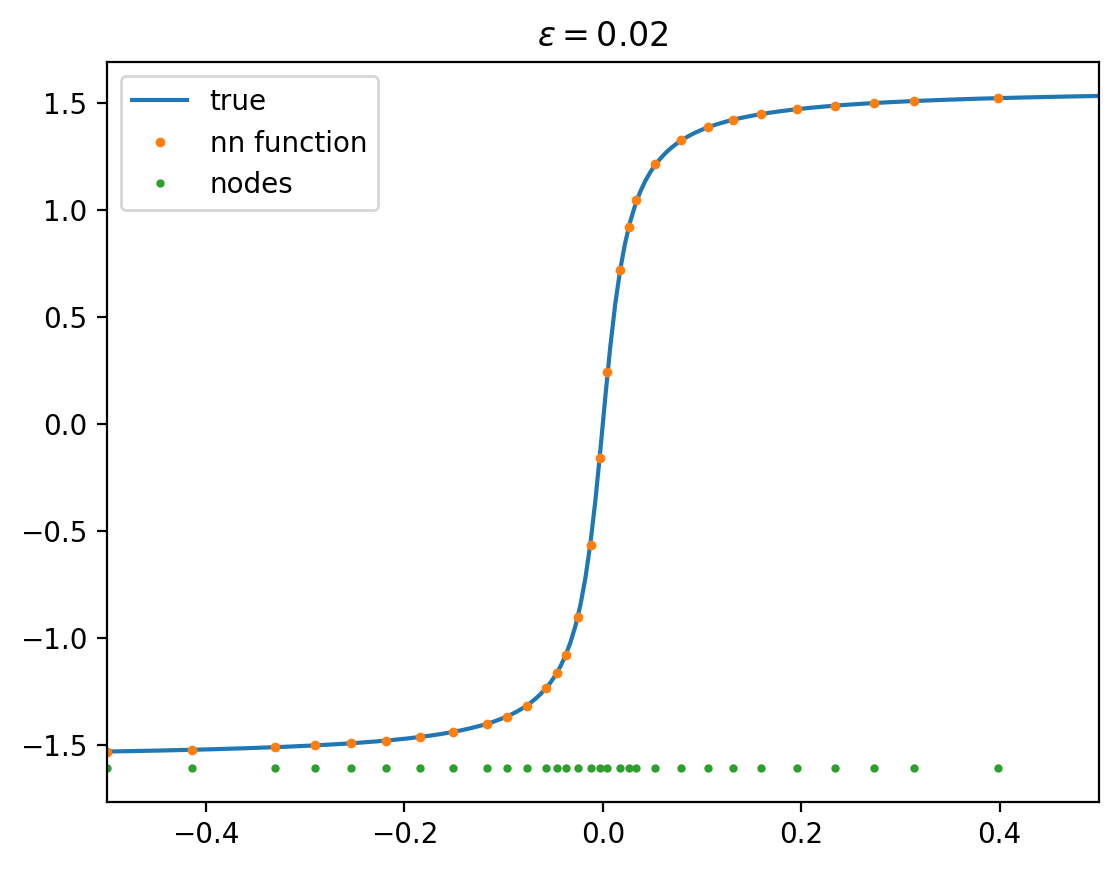

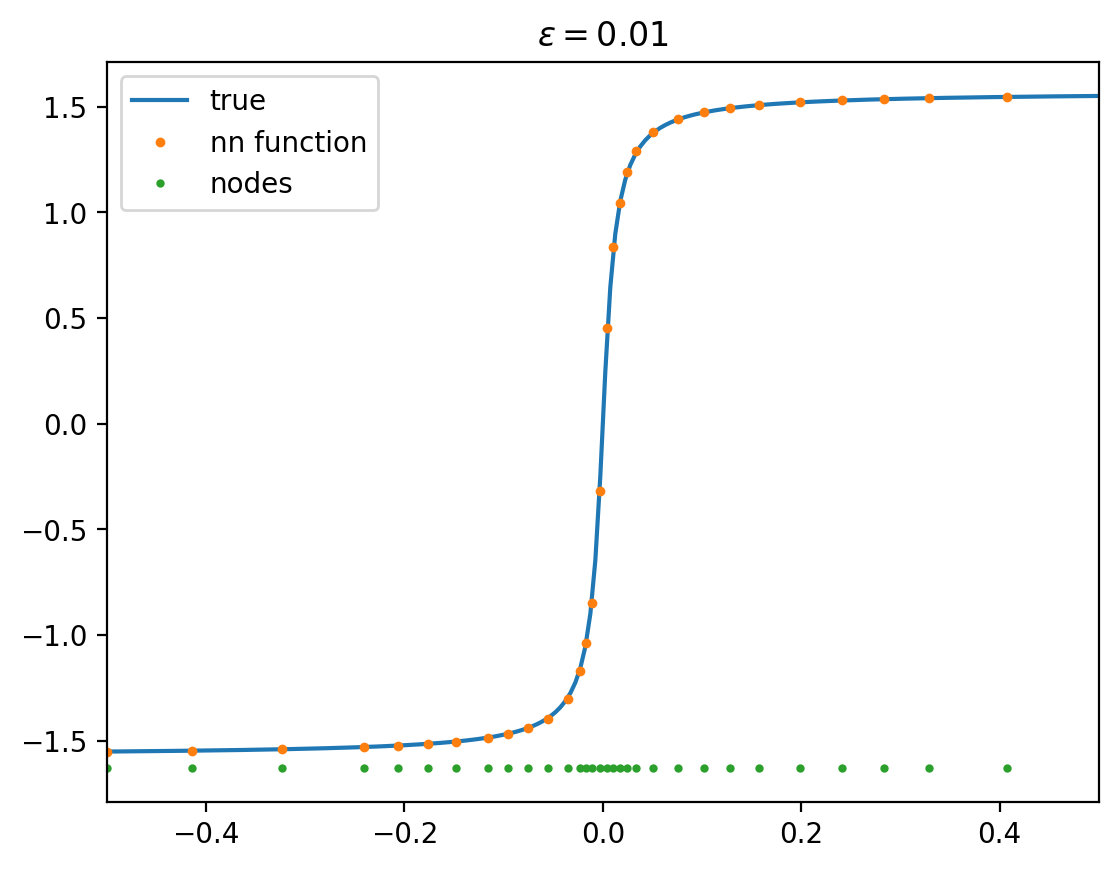

In [12]:
def make_target(alpha):
    return lambda x: torch.atan(alpha * x)

alphas = [20, 50, 100]

for alpha in alphas:
    function_name = f"arctan1d_alpha{alpha}"
    target = make_target(alpha) 
    for N in [2**11]:  # Can add more dictionary sizes here
        exponent = 5
        num_epochs = 2**exponent

        relu_k = 1
        my_model = model(input_size=1, hidden_size1=num_epochs, num_classes=1, k=relu_k)
        filename = f"model_cpu_OGA_1D_{function_name}_neuron_{num_epochs}_N_{N}_randomized.pt"
        my_model.load_state_dict(torch.load(filename))

        
        plot_solution_adaptive(-1/2, 1/2, my_model, target, name=f"$\\epsilon = {1/alpha}$")
        plot_parameters_on_circle_interactive(my_model)

In [ ]:


plot_parameters_on_circle_interactive(my_model) 